In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

import os

import numpy as np

from scipy.io import readsav

from mhsxtrapy.field2d import Field2dData, check_fluxbalance, FluxBalanceState, alpha_HS04

from mhsxtrapy.field3d import calculate_magfield, btemp_linear, bpressure_linear, bdensity_linear, fpressure_linear, fdensity_linear
from mhsxtrapy.b3d import WhichSolution

import matplotlib.pyplot as plt

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
/Users/lilli/Library/Caches/pypoetry/virtualenvs/mhsxtrapy-_witMKZG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
"""
LOAD DATA FROM FILE
"""

path = "data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type NOTICE
 - 29 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [4]:
"""
INSTANIATE RELEVANT PARAMETERS
"""

data_bz = data["b2dz5"] # Read magnetic field data in Gauss, see "Info Array" and "Info Unit" above.
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nx = data_bz.shape[1]
ny = data_bz.shape[0]

pz = 40.0 * 10**-3  # Convert pixelsize from km into Mm, see "Info Pixel" in previous cell.
px = 40.0 * 10**-3
py = 40.0 * 10**-3

xmin, ymin, zmin = 0.0, 0.0, 0.0
xmax = nx * px
ymax = ny * py
zmax = 4000.0 * 10**-3

nz = int(np.floor(zmax / pz))

nf = min(nx, ny)

x_arr = np.linspace(xmin, xmax, nx, dtype=np.float64)
y_arr = np.linspace(ymin, ymax, ny, dtype=np.float64)
z_arr = np.linspace(zmin, zmax, nz, dtype=np.float64)

In [5]:
"""
INSTANTIATE Field2dData OBJECT FROM LOW AND LOU BOUNDARY CONDITION
"""

data2d = Field2dData(
    nx,
    ny,
    nz,
    nf,
    px,
    py,
    pz,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
    flux_balance_state=FluxBalanceState.BALANCED,
)

In [6]:
"""
EXTRAPOLATE MAGNETIC FIELD
"""

data3d = calculate_magfield(
    data2d,
    alpha=-0.03,
    a=0.27,
    which_solution=WhichSolution.ASYMP,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
) 

In [7]:
"""
BACKGROUND ATMOSPHERE MODEL 1 
"""

btemp = data3d.btemp
bpressure = data3d.bpressure
bdensity = data3d.bdensity

fpressure = data3d.fpressure
fdensity = data3d.fdensity

current_density = data3d.j3D
lorentz_force = data3d.lf3D

In [8]:
"""
BACKGROUND ATMOSPHERE MODEL 2
"""
T_PHOTOSPHERE = 5600.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

temps = np.array([T_PHOTOSPHERE, 5200.0, T_CORONA]) # Kelvin
heights = np.array([0.0, 2.0, 4.0]) # Mm

btemp_lin = btemp_linear(data3d, heights, temps)
bpressure_lin = bpressure_linear(data3d, heights, temps)
bdensity_lin = bdensity_linear(data3d, heights, temps)

fpressure_lin = fpressure_linear(data3d, heights, temps)
fdensity_lin = fdensity_linear(data3d, heights, temps)

In [9]:
"""
ATMOSPHERIC PARAMETERS
"""

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm

T0 = (T_PHOTOSPHERE + T_CORONA * np.tanh(data3d.z0 / data3d.deltaz)) / ( # type:ignore
    1.0 + np.tanh(data3d.z0 / data3d.deltaz) # type:ignore
)  # in Kelvin
T1 = (T_CORONA - T_PHOTOSPHERE) / (
    1.0 + np.tanh(data3d.z0 / data3d.deltaz) # type:ignore
)  # in Kelvin
H = KB * T0 / (MBAR * G_SOLAR) / L  # in m

B0 = data3d.field[:, :, 0, 2].max()  # in Gauss

PB0 = (B0 * 10**-4) ** 2 / (
    2 * MU0
)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

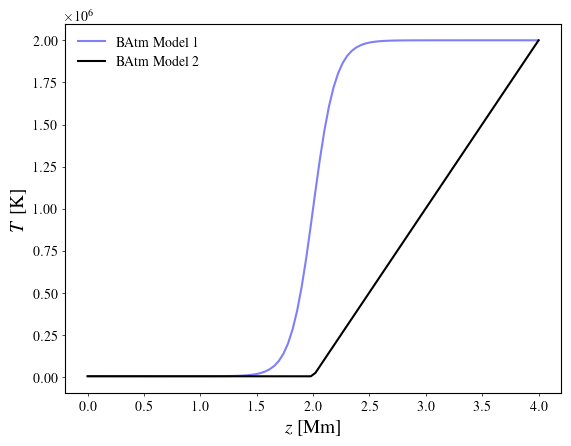

In [10]:
"""
TEMPERATURE [KELVIN]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, btemp,
    linewidth=1.5,
    color=(0.498, 0.502, 0.973), 
    label=r"BAtm Model 1",
)

ax.plot(
    z_arr, btemp_lin,
    linewidth=1.5,
    color="black",
    label=r"BAtm Model 2",
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)

ax.set_ylabel(r"$T$ [K]", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/temperature_kelvin.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

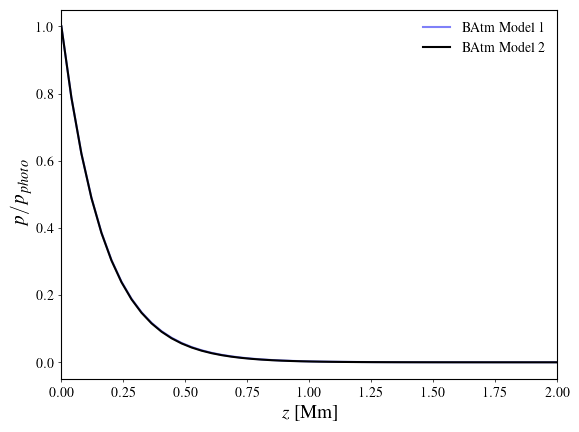

In [11]:
"""
PRESSURE [NORMALISED ON PHOTOSPHERE]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, bpressure,
    linewidth=1.5,
    color=(0.498, 0.502, 0.973), 
    label=r"BAtm Model 1",
)

ax.plot(
    z_arr, bpressure_lin,
    linewidth=1.5,
    color="black",
    label=r"BAtm Model 2",
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$p/p_{photo}$", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/pressure_normalised.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

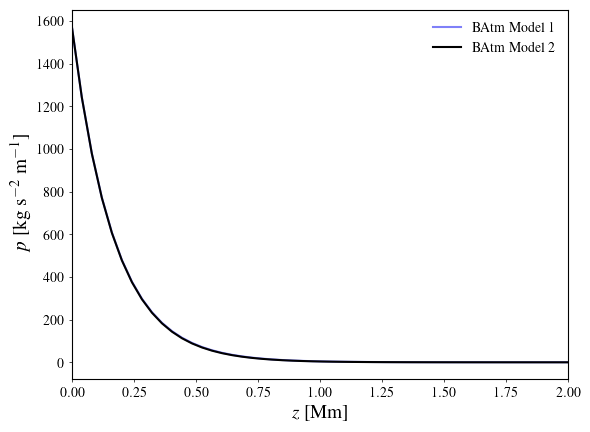

In [12]:
"""
PRESSURE [kg s^{-2} m^{-1}]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, bpressure * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=1.5,
    color=(0.498, 0.502, 0.973), 
    label=r"BAtm Model 1",
)

ax.plot(
    z_arr, bpressure_lin * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=1.5,
    color="black",
    label=r"BAtm Model 2",
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$p$ [kg s$^{-2}$ m$^{-1}$]", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/pressure_SI.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

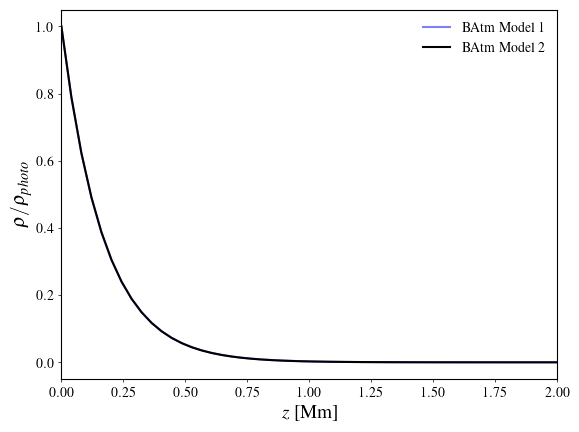

In [13]:
"""
DENSITY [NORMALISED ON PHOTOSPHERE]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, bdensity,
    linewidth=1.5,
    color=(0.498, 0.502, 0.973), 
    label=r"BAtm Model 1",
)

ax.plot(
    z_arr, bdensity_lin,
    linewidth=1.5,
    color="black",
    label=r"BAtm Model 2",
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$\rho / \rho_{photo}$", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/density_normalised.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

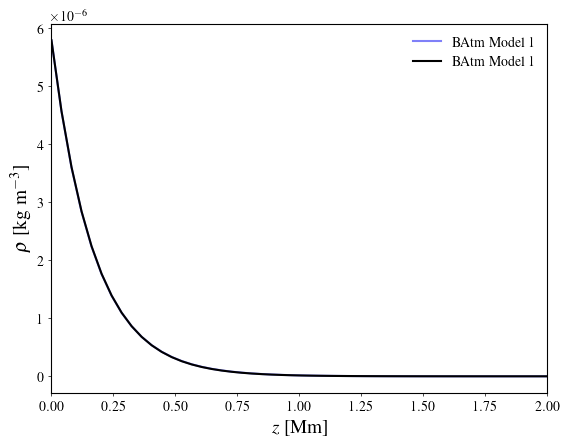

In [14]:
"""
DENSITY [kg m^{-3}]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, bdensity *(B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=1.5,
    color=(0.498, 0.502, 0.973), 
    label=r"BAtm Model 1",
)

ax.plot(
    z_arr, bdensity_lin *(B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=1.5,
    color="black",
    label=r"BAtm Model 1",
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$\rho$ [kg m$^{-3}$]", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/density_SI.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [15]:
"""
FIND X AND Y LOCATION OF MAXIMAL PHOTOSPHERIC Bz 
"""

ix_max = np.unravel_index(data3d.bz.argmax(), data3d.bz.shape)[1]
iy_max = np.unravel_index(data3d.bz.argmax(), data3d.bz.shape)[0]

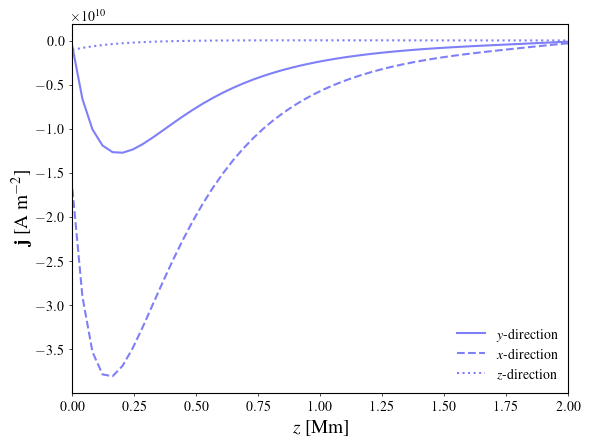

In [16]:
"""
CURRENT DENSITY AT ix_max, iy_max [A m^{-2}]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, current_density[iy_max, ix_max, :, 0],
    linewidth=1.5,
    label=r"$y$-direction",
    color=(0.498, 0.502, 0.973),
    linestyle="solid"
)
ax.plot(
    z_arr, current_density[iy_max, ix_max, :, 1],
    linewidth=1.5,
    label=r"$x$-direction",
    color=(0.498, 0.502, 0.973),  
    linestyle="dashed"
)
ax.plot(
    z_arr, current_density[iy_max, ix_max, :, 2],
    linewidth=1.5,
    label=r"$z$-direction",
    color=(0.498, 0.502, 0.973),
    linestyle="dotted"
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$\textbf{j}$ [A m$^{-2}$]", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/current-density_SI.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

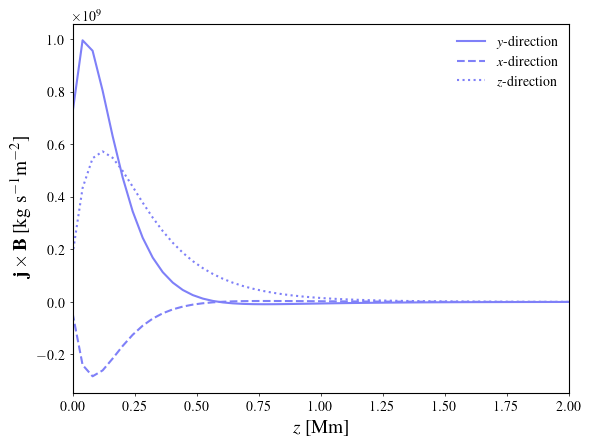

In [17]:
"""
LORENTZ FORCE AT ix_max, iy_max [kg s^{-1} m^{-2}]
"""

fig, ax = plt.subplots()

ax.plot(
    z_arr, lorentz_force[iy_max, ix_max, :, 0],
    linewidth=1.5,
    label=r"$y$-direction",
    color=(0.498, 0.502, 0.973),
    linestyle="solid"
)
ax.plot(
    z_arr, lorentz_force[iy_max, ix_max, :, 1],
    linewidth=1.5,
    label=r"$x$-direction",
    color=(0.498, 0.502, 0.973),
    linestyle="dashed"
)
ax.plot(
    z_arr, lorentz_force[iy_max, ix_max, :, 2],
    linewidth=1.5,
    label=r"$z$-direction",
    color=(0.498, 0.502, 0.973),
    linestyle="dotted"
)

ax.set_xlabel(r"$z$ [Mm]", size=14)
plt.legend(frameon=False)
ax.tick_params(direction="out", length=2, width=0.5)
ax.set_xlim([0, data3d.z0]) # type: ignore
ax.set_ylabel(r"$\textbf{j} \times \textbf{B}$ [kg s$^{-1}$m$^{-2}$]", size=14)
# Ensure the 'figures' directory exists
if not os.path.exists("figures"):
    os.makedirs("figures")

# Construct the dynamic plot name
plotname = f"figures/lorentz-force_SI.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()